In [47]:
import cv2
import numpy as np
from glob import glob
from sklearn.cluster import MiniBatchKMeans
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
filenames = [x for x in glob("../../data/fullpage_3k/image/*.png")]
print("got", len(filenames), "files")

('got', 1712, 'files')


0
(25, 90)


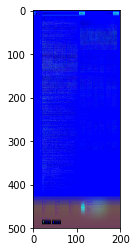

In [95]:
histograms = []
spectre = []
avg_screenshot = np.zeros((500, 200, 3), np.uint64)
N = 25
for i, filename in enumerate(filenames[:N]):
    if i % 25 == 0:
        print(i)
    img_bgr = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    hist3 = np.hstack([hist.astype(np.float64) / np.sum(hist) for hist, bins in [np.histogram(img[..., c].ravel(), 30, [0,256]) for c in range(3)]])
    histograms.append(hist3)
    
    small_img = cv2.resize(img, (200, 500))
    avg_screenshot += small_img
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (100, 100))
    spectrum = np.fft.fft2(img)
    fshift = np.fft.fftshift(spectrum)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    spectre.append(magnitude_spectrum)
    
    
    
avg_screenshot = (avg_screenshot / N).astype(np.uint8)
plt.imshow(avg_screenshot)
avg_screenshot = cv2.cvtColor(avg_screenshot, cv2.COLOR_HSV2BGR)
cv2.imwrite("mean_screenshot.jpg", avg_screenshot)

histograms = np.vstack(histograms)
spectre = np.dstack(spectre)
print(histograms.shape)

0.0


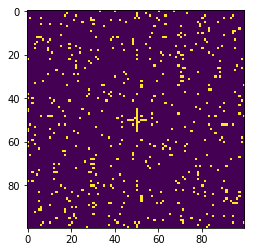

In [135]:
sd = np.std(spectre, axis=2)
sd[sd > np.percentile(sd, 5)] = 0
sd[sd > 0] = 1
plt.imshow(sd)
sp0 = spectre[..., 0]
sp1 = spectre[..., 0]
spdiff = np.abs(sp0 - sp1)
spdiff[sd < 1] = 0
print(spdiff.sum())

True

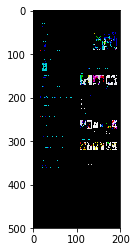

In [63]:
img = cv2.imread(filenames[0], cv2.IMREAD_COLOR)
img = cv2.resize(img, (200, 500))
img = cv2.absdiff(avg_screenshot, img)
img[img < 200] = 0
plt.imshow(img)
cv2.imwrite("diff.jpg", img)

8094.54852758565


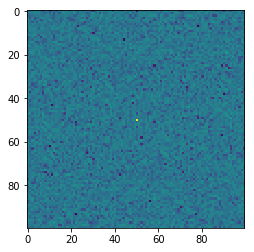

In [115]:
img = cv2.imread("img.png", cv2.IMREAD_GRAYSCALE)
img = 250 * np.random.rand(200, 200)
img = cv2.resize(img, (100, 100))
spectrum = np.fft.fft2(img)
fshift = np.fft.fftshift(spectrum)
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.imshow(magnitude_spectrum)
spdiff = np.abs(magnitude_spectrum - sp1)
spdiff[sd < 1] = 0
print(spdiff.sum())
# cv2.imwrite("spec.jpg", magnitude_spectrum.astype(np.uint8))

In [ ]:
img = cv2.imread(filenames[0], cv2.IMREAD_COLOR)
img = cv2.resize(img, (200, 500))
img = cv2.absdiff(avg_screenshot, img)
img[img < 200] = 0
plt.imshow(img)
cv2.imwrite("diff.jpg", img)

In [29]:
avg_hist = np.median(histograms, axis=0)
diff = np.abs(histograms - np.tile(avg_hist, (histograms.shape[0], 1)))
avg_diff = np.median(diff, axis=0)
percentile = 95
not_features = np.where(avg_diff > np.percentile(avg_diff, percentile) + 1e-6)[0]
print(np.where(avg_diff <= np.percentile(avg_diff, percentile) + 1e-6)[0])
diff[:, not_features] = 0
for i, diff_row in enumerate(diff):
    dist = np.dot(diff_row, diff_row)
    print(dist)

[ 1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 70 71 72 73 74 75
 76 77 78 79 80 81 82 83 84 85 86 87 88]
0.0006680334190692851
0.0009001417412433414
0.00018329429236125892
7.393976991251666e-05
0.0003459767983723614
0.0003155335936068251
0.000139287572753549
6.054242333570005e-05
0.0006613015671006789
0.00040922153397968553
9.42170536326162e-05
0.0009276726594136025
0.0004634358866705772
0.0011259652452143983
4.775247882533433e-05
0.00017580434234930334
0.0005384139586901096
0.0003123946565769223
0.00019325019094512395
0.0010061700432086066
0.00044452706506488063
0.0004222804233378876
5.470505614218713e-05
9.16672189162464e-05
0.0013771863213967875
0.00047942382571266435
7.072516087933794e-05
0.002563168710397103
0.000617474524275483
0.00034076930789027105
0.0002680345314932811
0.000317377321757035
0.0021347689608814373
9.80377258484

In [38]:
kmeans = MiniBatchKMeans(200)
labels = kmeans.fit_predict(histograms)
centroids = kmeans.cluster_centers_

In [39]:
def find_min_dist(hist, avg_hists):
    min_dist = 1e7
    for c in avg_hists:
        diff = hist - c
        diff[not_features] = 0
        dist = np.dot(diff, diff)
        if dist < min_dist:
            min_dist = dist
    return min_dist

max_dist = -1e7
for hist in histograms:
    dist = find_min_dist(hist, centroids)
    if dist > max_dist:
        max_dist= dist
print(max_dist)

0.0002982471850265566


In [44]:
img = 255 * np.ones((500, 500, 3), np.uint8)
img[..., 0] = 100
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hist3 = np.hstack([hist.astype(np.float64) / np.sum(hist) for hist, bins in [np.histogram(img[..., c].ravel(), 30, [0,256]) for c in range(3)]])
dist = find_min_dist(hist3, centroids)
print(dist)

1.9855913111467944
